# Californian Houses Model

## Loading Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import kagglehub

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

/home/stnz/coding/codenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Downloading The Data

In [2]:
path = kagglehub.dataset_download("fedesoriano/california-housing-prices-data-extra-features")

## Setting Up The Data Frame

In [3]:
df = pd.read_csv(path + '/California_Houses.csv')
df.sample(3)

,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
6482,191800.0,3.4286,32,1747,399,1199,402,34.09,-118.02,39938.162026,21026.475250,172358.783815,502403.892272,570426.179178
7955,170300.0,1.9903,18,2287,662,1804,537,33.88,-118.16,14380.505585,20648.093463,159305.523983,511298.178273,579308.041275
4166,166300.0,1.9355,37,2040,611,1698,545,34.11,-118.20,30027.442108,7579.061121,182574.019022,489582.995989,557618.083564


## EDA

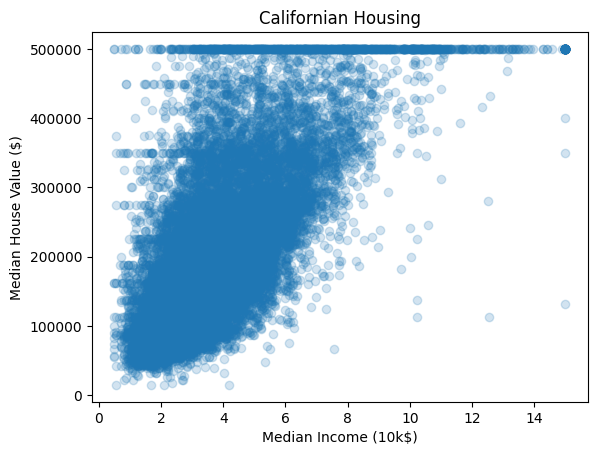

In [4]:
plt.scatter(df['Median_Income'], df['Median_House_Value'], alpha=0.2)
plt.title("Californian Housing")
plt.xlabel("Median Income (10k$)")
plt.ylabel("Median House Value ($)")
plt.show()

Clearly the houses with half a million dollars value aren't affected much by the income.
But in most cases (when the median income is bellow 10) the income does have a direct interfirence on the median house value.

## Spliting The Data

In [5]:
train_features, test_features, train_prices, test_prices = \
    train_test_split(df.drop("Median_House_Value", axis=1), df["Median_House_Value"], test_size=0.3, random_state=777)

Now there is data to train the model and also some data to be compared to the preditions - to check the validity of the predictions that are made by the model.

## Outliers Identification

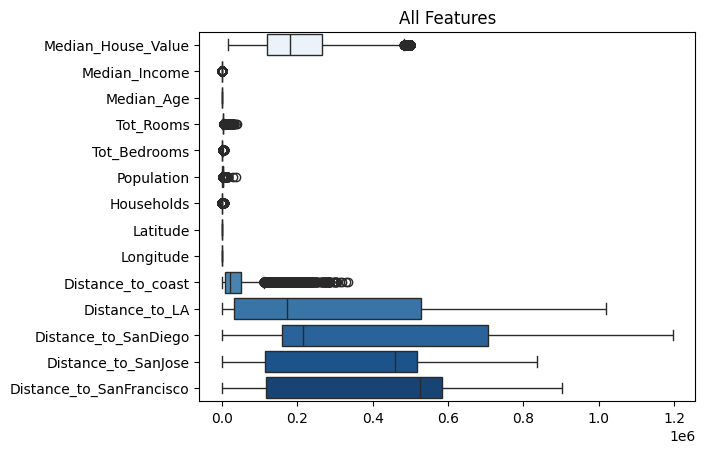

In [6]:
plt.title("All Features")
sns.boxplot(data=df, orient="h", palette="Blues")
plt.show()

### Making It Cleaner

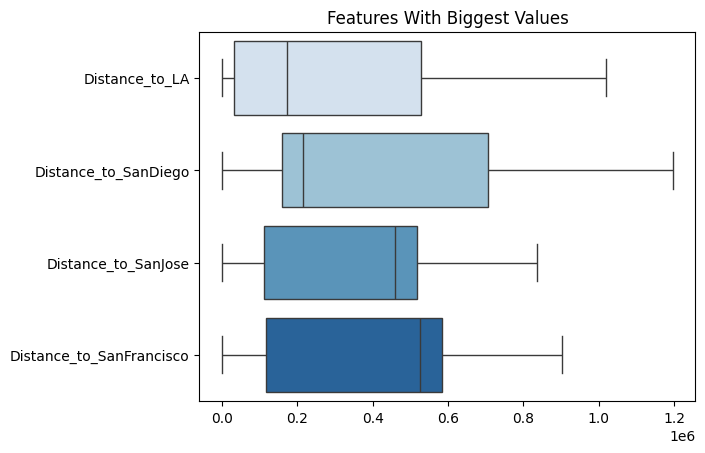

In [7]:
biggest_values = ["Distance_to_LA", "Distance_to_SanDiego", "Distance_to_SanJose", "Distance_to_SanFrancisco"]
plt.title("Features With Biggest Values")
sns.boxplot(data=df[biggest_values], orient="h", palette="Blues")
plt.show()

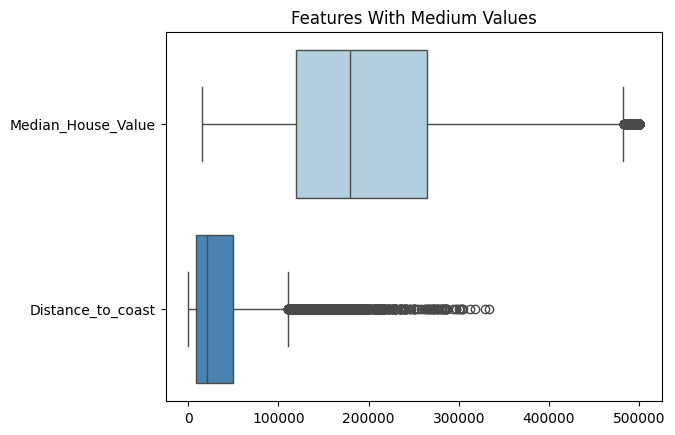

In [8]:
medium_values = ["Median_House_Value", "Distance_to_coast"]
plt.title("Features With Medium Values")
sns.boxplot(data=df[medium_values], orient="h", palette="Blues")
plt.show()

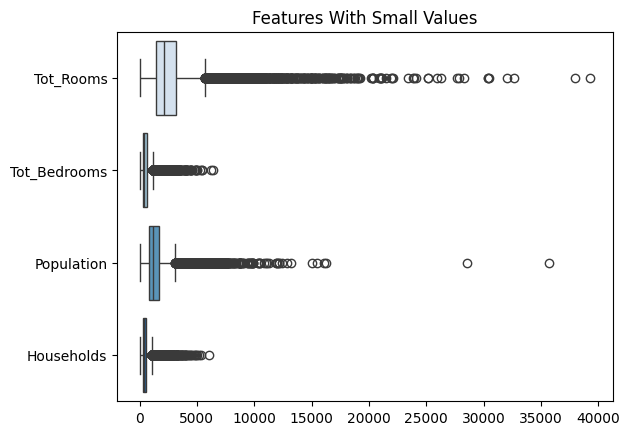

In [9]:
small_values = ["Tot_Rooms", "Tot_Bedrooms", "Population", "Households"]
plt.title("Features With Small Values")
sns.boxplot(data=df[small_values], orient="h", palette="Blues")
plt.show()

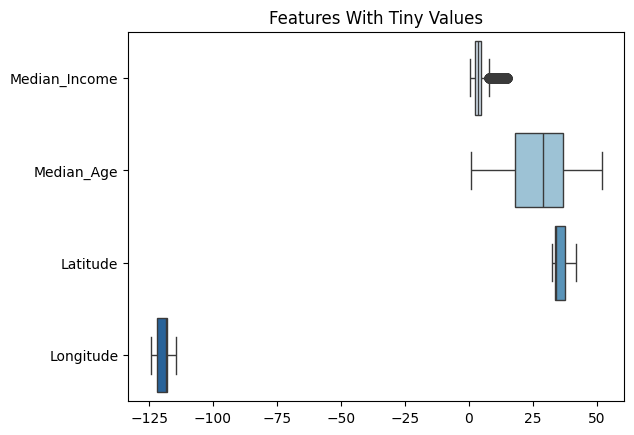

In [10]:
tiny_values = ["Median_Income", "Median_Age", "Latitude", "Longitude"]
plt.title("Features With Tiny Values")
sns.boxplot(data=df[tiny_values], orient="h", palette="Blues")
plt.show()

### Conclusion

Most of the outliers are positive values. The outliers also seem to be natural.
It's natural to have cities and houses that are way above the average and same applies to the incomes and houses values.

## Features Selection (Regression, All vs Selected Features)

In [11]:
def evaluate_linear_regression(train_data, test_data, train_prices, test_prices):
    model = LinearRegression()
    model.fit(train_data, train_prices)

    model_predictions = model.predict(test_data)

    mae = mean_absolute_error(test_prices, model_predictions)
    rmse = np.sqrt(mean_squared_error(test_prices, model_predictions))
    r2 = r2_score(test_prices, model_predictions)

    return [mae, rmse, r2]

In [12]:
evaluations_df = pd.DataFrame({
    "mae" : [],
    "rmse" : [],
    "r2" : []
})

#### Using All Features

In [13]:
metrics = evaluate_linear_regression(train_features, test_features, train_prices, test_prices)

evaluations_df.loc["Linear Regression (All Features)"] = metrics

#### Using Selected Features

In [14]:
selection = ["Median_Income", "Median_Age", "Tot_Rooms"]

In [15]:
metrics = evaluate_linear_regression(train_features[selection], test_features[selection], train_prices, test_prices)

evaluations_df.loc["Linear Regression (Selected Features)"] = metrics

### Normalized

#### Standard

##### Using All Features

In [16]:
scaler = StandardScaler()

std = scaler.fit_transform(df.drop("Median_House_Value", axis=1))

train_features_std, test_features_std, train_prices_std, test_prices_std = \
    train_test_split(std, df["Median_House_Value"], test_size=0.3, random_state=777)

In [17]:
metrics = evaluate_linear_regression(train_features_std, test_features_std, train_prices_std, test_prices_std)

evaluations_df.loc["Linear Regression (All Features, Z-Score)"] = metrics

##### Using Selected Features

In [18]:
scaler = StandardScaler()

std = scaler.fit_transform(df[selection])

train_features_std, test_features_std, train_prices_std, test_prices_std = \
    train_test_split(std, df["Median_House_Value"], test_size=0.3, random_state=777)

In [19]:
metrics = evaluate_linear_regression(train_features_std, test_features_std, train_prices_std, test_prices_std)

evaluations_df.loc["Linear Regression (Selected Features, Z-Score)"] = metrics

#### Min-Max

##### Using All Features

In [20]:
scaler = MinMaxScaler()

minmax = scaler.fit_transform(df.drop("Median_House_Value", axis=1))
    
train_features_minmax, test_features_minmax, train_prices_minmax, test_prices_minmax = \
    train_test_split(minmax, df["Median_House_Value"], test_size=0.3, random_state=777)

In [21]:
metrics = evaluate_linear_regression(train_features_minmax, test_features_minmax, train_prices_minmax, test_prices_minmax)

evaluations_df.loc["Linear Regression (All Features, Min-Max)"] = metrics

##### Using Selected Features

In [22]:
scaler = MinMaxScaler()

minmax = scaler.fit_transform(df[selection])
    
train_features_minmax, test_features_minmax, train_prices_minmax, test_prices_minmax = \
    train_test_split(minmax, df["Median_House_Value"], test_size=0.3, random_state=777)

In [23]:
metrics = evaluate_linear_regression(train_features_minmax, test_features_minmax, train_prices_minmax, test_prices_minmax)

evaluations_df.loc["Linear Regression (Selected Features, Min-Max)"] = metrics

#### Log

##### Using All Features

In [24]:
# There only logs for positive values and all longitudes are negatives so...
df_log = df.drop("Median_House_Value", axis=1)
df_log["Longitude"] *= -1

log = np.log1p(df_log)
    
train_features_log, test_features_log, train_prices_log, test_prices_log = \
    train_test_split(log, df["Median_House_Value"], test_size=0.3, random_state=777)

In [25]:
metrics = evaluate_linear_regression(train_features_log, test_features_log, train_prices_log, test_prices_log)

evaluations_df.loc["Linear Regression (All Features, Logarithm)"] = metrics

##### Using Selected Features

In [26]:
metrics = evaluate_linear_regression(train_features_log[selection], test_features_log[selection], train_prices_log, test_prices_log)

evaluations_df.loc["Linear Regression (Selected Features, Logarithm)"] = metrics

### Regressions Results

In [27]:
evaluations_df.sort_values(by="mae")

,mae,rmse,r2
"Linear Regression (All Features, Logarithm)",49286.016686,65727.846870,0.666590
Linear Regression (All Features),49350.799884,67906.895444,0.644117
"Linear Regression (All Features, Z-Score)",49350.799884,67906.895444,0.644117
"Linear Regression (All Features, Min-Max)",49350.799884,67906.895444,0.644117
"Linear Regression (Selected Features, Min-Max)",60043.914786,80594.967327,0.498703
Linear Regression (Selected Features),60043.914786,80594.967327,0.498703
"Linear Regression (Selected Features, Z-Score)",60043.914786,80594.967327,0.498703
"Linear Regression (Selected Features, Logarithm)",62713.672457,82559.757274,0.473963


The features selection was required, furthermore it seems that the data without a feature selection turned out to be better suited for the job, based on the required metric (minimun absolute error, MAE).

## Decision Tree Vs Linear Regression

In [28]:
def evaluate_decision_tree(train_data, test_data, train_prices, test_prices):
    model = DecisionTreeRegressor(random_state=777)
    model.fit(train_data, train_prices)

    model_predictions = model.predict(test_data)

    mae = mean_absolute_error(test_prices, model_predictions)
    rmse = np.sqrt(mean_squared_error(test_prices, model_predictions))
    r2 = r2_score(test_prices, model_predictions)

    return [mae, rmse, r2]

#### Using All Features

In [29]:
metrics = evaluate_decision_tree(train_features, test_features, train_prices, test_prices)

evaluations_df.loc["Decision Tree (All Features)"] = metrics

#### Using Selected Features

In [30]:
selection = ["Median_Income", "Median_Age", "Tot_Rooms"]

In [31]:
metrics = evaluate_decision_tree(train_features[selection], test_features[selection], train_prices, test_prices)

evaluations_df.loc["Decision Tree (Selected Features)"] = metrics

### Normalized

#### Standard

##### Using All Features

In [32]:
scaler = StandardScaler()

std = scaler.fit_transform(df.drop("Median_House_Value", axis=1))

train_features_std, test_features_std, train_prices_std, test_prices_std = \
    train_test_split(std, df["Median_House_Value"], test_size=0.3, random_state=777)

In [33]:
metrics = evaluate_decision_tree(train_features_std, test_features_std, train_prices_std, test_prices_std)

evaluations_df.loc["Decision Tree (All Features, Z-Score)"] = metrics

##### Using Selected Features

In [34]:
scaler = StandardScaler()

std = scaler.fit_transform(df[selection])

train_features_std, test_features_std, train_prices_std, test_prices_std = \
    train_test_split(std, df["Median_House_Value"], test_size=0.3, random_state=777)

In [35]:
metrics = evaluate_decision_tree(train_features_std, test_features_std, train_prices_std, test_prices_std)

evaluations_df.loc["Decision Tree (Selected Features, Z-Score)"] = metrics

#### Min-Max

##### Using All Features

In [36]:
scaler = MinMaxScaler()

minmax = scaler.fit_transform(df.drop("Median_House_Value", axis=1))
    
train_features_minmax, test_features_minmax, train_prices_minmax, test_prices_minmax = \
    train_test_split(minmax, df["Median_House_Value"], test_size=0.3, random_state=777)

In [37]:
metrics = evaluate_decision_tree(train_features_minmax, test_features_minmax, train_prices_minmax, test_prices_minmax)

evaluations_df.loc["Decision Tree (All Features, Min-Max)"] = metrics

##### Using Selected Features

In [38]:
scaler = MinMaxScaler()

minmax = scaler.fit_transform(df[selection])
    
train_features_minmax, test_features_minmax, train_prices_minmax, test_prices_minmax = \
    train_test_split(minmax, df["Median_House_Value"], test_size=0.3, random_state=777)

In [39]:
metrics = evaluate_decision_tree(train_features_minmax, test_features_minmax, train_prices_minmax, test_prices_minmax)

evaluations_df.loc["Decision Tree (Selected Features, Min-Max)"] = metrics

#### Log

##### Using All Features

In [40]:
# There only logs for positive values and all longitudes are negatives so...
df_log = df.drop("Median_House_Value", axis=1)
df_log["Longitude"] *= -1

log = np.log1p(df_log)
    
train_features_log, test_features_log, train_prices_log, test_prices_log = \
    train_test_split(log, df["Median_House_Value"], test_size=0.3, random_state=777)

In [41]:
metrics = evaluate_decision_tree(train_features_log, test_features_log, train_prices_log, test_prices_log)

evaluations_df.loc["Decision Tree (All Features, Logarithm)"] = metrics

##### Using Selected Features

In [42]:
metrics = evaluate_decision_tree(train_features_log[selection], test_features_log[selection], train_prices_log, test_prices_log)

evaluations_df.loc["Decision Tree (Selected Features, Logarithm)"] = metrics

### Regressions Results

In [43]:
evaluations_df.sort_values(by="mae")

,mae,rmse,r2
"Decision Tree (All Features, Logarithm)",42067.285207,67217.901891,0.651302
Decision Tree (All Features),42186.357235,67491.515969,0.648458
"Decision Tree (All Features, Z-Score)",42229.316376,67529.416255,0.648063
"Decision Tree (All Features, Min-Max)",42250.827519,67553.779794,0.647809
"Linear Regression (All Features, Logarithm)",49286.016686,65727.846870,0.666590
Linear Regression (All Features),49350.799884,67906.895444,0.644117
"Linear Regression (All Features, Z-Score)",49350.799884,67906.895444,0.644117
"Linear Regression (All Features, Min-Max)",49350.799884,67906.895444,0.644117
"Linear Regression (Selected Features, Min-Max)",60043.914786,80594.967327,0.498703
Linear Regression (Selected Features),60043.914786,80594.967327,0.498703


### Conclusion

The Decision Tree using all features and having being normalized with a logarithm is the best overall minimun absolute error (mae). 